<a href="https://colab.research.google.com/github/wojciechsadlik/MGU-CGANMusicConverter/blob/main/raw_audio_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/MGU-CGANMusicConverter

/content/drive/MyDrive/Colab Notebooks/MGU-CGANMusicConverter


In [3]:
import os
import pickle
import numpy as np
from glob import glob
from keras.utils.np_utils import to_categorical

In [4]:
def get_data(file_list):
  def load_into(filename, x, y):
    with open(filename, 'rb') as f:
      pkl_file = pickle.load(f)
      x.append(pkl_file['audio'])
      y.append(int(pkl_file['class_id']))

  x, y = [], []
  for filename in file_list:
    load_into(filename, x, y)

  return np.array(x), np.array(y)

In [5]:
from keras.layers.pooling import MaxPooling1D
from keras.backend import in_top_k
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras import regularizers, Input
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Activation
from keras.layers import LeakyReLU, Add, Dense, Flatten
from tensorflow.keras.utils import plot_model

AUDIO_LENGTH = 110250

def add_Res1D(y, kernel_size, filters, strides=1, downsample=False):
  y_shortcut = y

  y = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(y)
  y = BatchNormalization()(y)

  if downsample or strides > 1:
    y_shortcut = Conv1D(filters=filters, kernel_size=1, strides=strides, padding='same')(y_shortcut)

  y = Add()([y_shortcut, y])
  y = LeakyReLU()(y)

  return y


def build_discriminator(input_shape=[AUDIO_LENGTH, 1]):

  X_input = Input(input_shape)
  
  y = Conv1D(128, kernel_size=3, strides=3, padding='same')(X_input)
  y = add_Res1D(y, 3, 128)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 128)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256, downsample=True)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 512, downsample=True)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = Conv1D(512, kernel_size=1, strides=1, padding='same')(y)
  y = Flatten()(y)
  y = Dense(1, activation='sigmoid')(y)

  model = Model(inputs = X_input, outputs = y)

  #model.summary()

  return model

In [6]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
from keras.layers.convolutional import Conv1DTranspose
from keras.layers import Reshape

LATENT_DIM = 98

def build_generator(input_shape=(LATENT_DIM, )):

  X_input = Input(input_shape)
  
  y = Dense(input_shape[0] * 128)(X_input)
  y = Reshape((input_shape[0], 128))(y)
  y = Conv1DTranspose(128, kernel_size=7, strides=5, padding='same')(y)
  y = LeakyReLU()(y)
  y = Conv1DTranspose(128, kernel_size=7, strides=5, padding='same')(y)
  y = LeakyReLU()(y)
  y = Conv1DTranspose(256, kernel_size=7, strides=5, padding='same')(y)
  y = LeakyReLU()(y)
  y = Conv1DTranspose(256, kernel_size=3, strides=3, padding='same')(y)
  y = LeakyReLU()(y)
  #y = Conv1DTranspose(512, kernel_size=3, strides=3, padding='same')(y)
  #y = LeakyReLU()(y)
  y = Conv1DTranspose(1, kernel_size=3, strides=3, padding='same', activation='tanh')(y)
  #y = LeakyReLU()(y)
  #y = Conv1D(1, kernel_size=3, padding='same', activation='tanh')(y)


  model = Model(inputs = X_input, outputs = y)

  #model.summary()

  return model

In [8]:
generator = build_generator()

In [9]:
z = Input(shape=(LATENT_DIM,))
sample = generator(z)
discriminator.trainable = False
valid = discriminator(sample)
combined_model = Model(z, valid)
combined_model.compile(loss='binary_crossentropy', optimizer='adam')

In [10]:
batch_size = 32

valid_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

epochs = 3

DATASET_PATH = './audio_splitting/genres/jazz'
SAMPLES_LIST = os.listdir(DATASET_PATH)
SAMPLES_NUM = len(SAMPLES_LIST)

In [11]:
batches_num = int(SAMPLES_NUM/batch_size)

for epoch in range(epochs):
  idx = np.arange(SAMPLES_NUM)
  np.random.shuffle(idx)

  d_loss_sum = 0
  d_acc_sum = 0
  g_loss_sum = 0

  for batch in range(batches_num):
    batch_idx = idx[batch*batch_size : (batch+1)*batch_size]
    
    real_samples, _ = get_data([
        os.path.join(DATASET_PATH, SAMPLES_LIST[i]) for i in batch_idx
      ])
    
    #print("%d : batch %d samples loaded" % (epoch, batch))

    noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
    gen_samples = generator.predict(noise)

    #print('fake samples generated')

    d_loss_real = discriminator.train_on_batch(real_samples, valid_labels)
    d_loss_fake = discriminator.train_on_batch(gen_samples, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = combined_model.train_on_batch(noise, valid_labels)

    d_loss_sum += d_loss[0]
    d_acc_sum += d_loss[1]
    g_loss_sum += g_loss

  print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]"
    % (epoch, d_loss_sum/batches_num, 100*d_acc_sum/batches_num, g_loss/batches_num))

0 [D loss: 4.746317, acc.: 82.99%] [G loss: 0.007561]
1 [D loss: 0.000285, acc.: 100.00%] [G loss: 0.000023]
2 [D loss: 0.000119, acc.: 100.00%] [G loss: 0.000008]


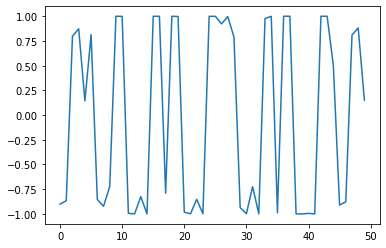

In [28]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (1, LATENT_DIM))
gen_sample = generator.predict(noise)
gen_sample = gen_sample.reshape(AUDIO_LENGTH, 1)

plt.plot(gen_sample[100000 : 100050])
plt.show()